In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio
import sys
from collections import defaultdict, deque
import networkx as nx
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import HTML

In [2]:
# Initialize the Gmsh API
gmsh.initialize()

# Create a new model
gmsh.model.add("cube")

# Define the length of the cube sides
L = 1.0

# Define characteristic lengths
mesh_size = 0.9  # You can adjust this to control the element size

# Define points of the cube with the specified mesh size
p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size)
p2 = gmsh.model.geo.addPoint(L, 0, 0, mesh_size)
p3 = gmsh.model.geo.addPoint(L, L, 0, mesh_size)
p4 = gmsh.model.geo.addPoint(0, L, 0, mesh_size)
p5 = gmsh.model.geo.addPoint(0, 0, L, mesh_size)
p6 = gmsh.model.geo.addPoint(L, 0, L, mesh_size)
p7 = gmsh.model.geo.addPoint(L, L, L, mesh_size)
p8 = gmsh.model.geo.addPoint(0, L, L, mesh_size)

# Create lines between the points to form the cube edges
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

l5 = gmsh.model.geo.addLine(p1, p5)
l6 = gmsh.model.geo.addLine(p2, p6)
l7 = gmsh.model.geo.addLine(p3, p7)
l8 = gmsh.model.geo.addLine(p4, p8)

l9 = gmsh.model.geo.addLine(p5, p6)
l10 = gmsh.model.geo.addLine(p6, p7)
l11 = gmsh.model.geo.addLine(p7, p8)
l12 = gmsh.model.geo.addLine(p8, p5)

# Define surfaces of the cube
# Bottom face
bottom_face = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
gmsh.model.geo.addPlaneSurface([bottom_face])

# Top face
top_face = gmsh.model.geo.addCurveLoop([l9, l10, l11, l12])
gmsh.model.geo.addPlaneSurface([top_face])

# Four side faces
face1 = gmsh.model.geo.addCurveLoop([l1, l6, -l9, -l5])
gmsh.model.geo.addPlaneSurface([face1])

face2 = gmsh.model.geo.addCurveLoop([l2, l7, -l10, -l6])
gmsh.model.geo.addPlaneSurface([face2])

face3 = gmsh.model.geo.addCurveLoop([l3, l8, -l11, -l7])
gmsh.model.geo.addPlaneSurface([face3])

face4 = gmsh.model.geo.addCurveLoop([l4, l5, -l12, -l8])
gmsh.model.geo.addPlaneSurface([face4])

# Create a volume by joining the surfaces
volume_loop = gmsh.model.geo.addSurfaceLoop([1, 2, 3, 4, 5, 6])
gmsh.model.geo.addVolume([volume_loop])

# Synchronize the model
gmsh.model.geo.synchronize()

# Generate the 3D mesh
gmsh.model.mesh.generate(3)

# Optionally, save the mesh to a file
gmsh.write("cube.msh")

# gmsh.fltk.run()

# Finalize the gmsh API
gmsh.finalize()

In [3]:
# Extract the nodes that make up each tetrahedron
# Load the mesh from the saved .msh file
mesh = meshio.read("cube.msh")

# Get the node coordinates
nodes = mesh.points  # This gives an array of all the nodes and their coordinates
# print("Nodes (coordinates):")
# print(nodes.shape)

# Get the tetrahedral elements (the connectivity information)
tetrahedrons = mesh.cells_dict.get("tetra")
# if tetrahedrons is not None:
#     print("Tetrahedral elements (node indices):")
#     print(tetrahedrons)
# else:
#     print("No tetrahedral elements found.")

# Get the edges of the tetrahedrons (connectivity of edges)
tetras_to_edges = defaultdict(list)
edges_to_tetras = defaultdict(list)
edges = []
for i, tetra in enumerate(tetrahedrons):
    # Each tetrahedron has 6 edges (combination of 4 vertices taken 2 at a time)
    edges.append(sorted([tetra[0], tetra[1]]))
    edges.append(sorted([tetra[0], tetra[2]]))
    edges.append(sorted([tetra[0], tetra[3]]))
    edges.append(sorted([tetra[1], tetra[2]]))
    edges.append(sorted([tetra[1], tetra[3]]))
    edges.append(sorted([tetra[2], tetra[3]]))

    # Map each tetrahedron to its edges
    tetras_to_edges[i].append(sorted([tetra[0], tetra[1]]))
    tetras_to_edges[i].append(sorted([tetra[0], tetra[2]]))
    tetras_to_edges[i].append(sorted([tetra[0], tetra[3]]))
    tetras_to_edges[i].append(sorted([tetra[1], tetra[2]]))
    tetras_to_edges[i].append(sorted([tetra[1], tetra[3]]))
    tetras_to_edges[i].append(sorted([tetra[2], tetra[3]]))

# Removing duplicate edges (since each shared edge will appear twice in the tetrahedron)
edges = np.array([list(edge) for edge in set(tuple(sorted(edge)) for edge in edges)])
# print("Tetrahedral edges (node indices):")
# print(edges)

# for i, tetra_edges in enumerate(tetras_to_edges.items()):
#     print(np.array(tetra_edges[1]).shape)


In [4]:
# Function to extract the faces of a tetrahedron
def extract_faces(tet):
    # Each tet has 4 faces, formed by taking 3 nodes at a time out of 4
    faces = [
        sorted([tet[0], tet[1], tet[2]]),
        sorted([tet[0], tet[1], tet[3]]),
        sorted([tet[0], tet[2], tet[3]]),
        sorted([tet[1], tet[2], tet[3]])
    ]
    return faces

# Extract the faces for each tet
all_faces = []
for tet in tetrahedrons:
    faces = extract_faces(tet)
    all_faces.extend(faces)

all_faces = np.array(all_faces)

# print(all_faces)
# print(all_faces.shape)

# Remove duplicate faces 
unique_faces = set(tuple(face) for face in all_faces)
unique_faces = np.array(list(unique_faces))

# print(unique_faces.shape)

In [5]:
# Map each tetrahedrons to its faces and vice versa
# Create a dictionary to map each tetrahedron to its faces
tets_to_faces = {}

# Create a dictionary to map each face to the tets that have said face
faces_to_tets = defaultdict(list)

# Iterate over tets and build the mappings
for i, tet in enumerate(tetrahedrons):
    # Extract faces of current tetrahedron 
    faces = extract_faces(tet)

    # Map the current tet to its faces
    tets_to_faces[i] = faces

    # Map each face to the current tet
    for face in faces:
        faces_to_tets[tuple(face)].append(i)

# Separate boundary faces from internal faces
# Boundary faces will have only one tet corresponding to it
boundary_faces = {}

# Internal faces will have 2 tets corresponding to it
internal_faces = {}

for face, tets in faces_to_tets.items():
    if len(tets) == 1:
        boundary_faces[face] = tets[0]
    else:
        internal_faces[face] = tets

# for face, tet in boundary_faces.items():
#     print(f"Face {face} is boundary face of tet {tet}")

# for face, tets in internal_faces.items():
    # print(f"Face {face} is internal face for tets {tets}")

In [6]:
# Generate discrete directions
n_polar = 6
n_azi   = 6

# Polar angles
mus, _ = np.polynomial.legendre.leggauss(n_polar)
# print(mus)

# Azimuthal angles
azis, d_azi = np.linspace(0, 2*np.pi, num=n_azi, endpoint=False, retstep=True)
azis += d_azi/2.0 # "shift" the angles to avoid 0
# print(azis)

# Plot discrete direction vectors on 3D unit sphere
x_vals = []
y_vals = []
z_vals = []
for mu in mus:
    for azi in azis:
        x = np.sqrt(1-mu**2)*np.cos(azi)
        y = np.sqrt(1-mu**2)*np.sin(azi)
        z = mu

        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(z)

# Store direction vectors
dir_vecs = list(zip(x_vals, y_vals, z_vals))
# print(dir_vecs)

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111, projection="3d")

# Plot the sphere
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="black",
                alpha=0.3)

# Plot the discrete direction vectors as points
ax.scatter(x_vals, y_vals, z_vals, color="red")

# Plot x-, y-, and z-axes going through the sphere
# ax.plot([-1, 1], [0, 0], [0, 0], color='black')  # X-axis
# ax.plot([0, 0], [-1, 1], [0, 0], color='black')  # Y-axis
# ax.plot([0, 0], [0, 0], [-1, 1], color='black')  # Z-axis

# Set plot limits and labels
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

<IPython.core.display.Javascript object>

In [7]:
# Compute a normal vector for the face of a tetrahedron,
# which are defined by the nodes that make up the face
def compute_normal(tet_face):
    # Extract the coordinates of the face nodes
    node1 = nodes[tet_face[0]]
    node2 = nodes[tet_face[1]]
    node3 = nodes[tet_face[2]]

    # Get two edges of the face
    edge1 = node2 - node1
    edge2 = node3 - node1

    # Compute the cross product of the two edges, which is normal
    # to the face by construction
    normal = np.cross(edge1, edge2)
    normal /= np.linalg.norm(normal)

    return normal

# Compute the outward normal to a face defined by 
# (node1, node2, node3)
# node4 is a node of the tet that doesn't make up the above face
def compute_outward_normal(tet_face, node4):
    normal = compute_normal(tet_face)

    # Edge that is in the direction of the outward normal
    # (node1 can be replaced with either node2 or node3)
    edge = nodes[tet_face[0]] - nodes[node4]

    if np.dot(normal, edge) < 0.0:
        normal = -normal
    
    return normal

In [8]:
# For each tet, compute its outward facing normals 
tets_normals = defaultdict(list)

for tet_idx, tet in enumerate(tetrahedrons):
    faces = tets_to_faces[tet_idx]
    
    for face in faces:
        # Get the tet node that doesn't make up this face
        node4 = set(tet) - set(face); node4 = node4.pop()

        ow_normal = compute_outward_normal(face, node4)
        tets_normals[tet_idx].append(ow_normal)

In [9]:
def reduce_deps(tet_idx, nbr_deps_per_tet, deps_per_tet, \
                solve_buffer, task_graph):
    # Loop over the neighboring tets of the given tet
    # to reduce their dependencies as the given tet is already solved,
    # and transmit information to its neighbors
    for nbr_idx in nbr_deps_per_tet[tet_idx]:
        # Add directed edge from the current tet to the neighboring tet,
        # but do so only if the edge is not already in the task graph
        if not task_graph.has_edge(tet_idx, nbr_idx):
            task_graph.add_edge(tet_idx, nbr_idx)

        # Reduce the number of dependencies of neighboring tet
        # by 1 since one of its edges has received information from the same
        # edge of the current tet
        deps_per_tet[nbr_idx] -= 1

        # If the neighboring tet has 0 dependencies, add it to the buffer
        # of tets that are ready to solve
        if deps_per_tet[nbr_idx] == 0:
            solve_buffer.append(nbr_idx)

In [10]:
# Store task graph for each direction vector
task_graphs = []

for i, dir in enumerate(dir_vecs):
    # Map to store the number of dependecies for each tet
    # Each tet starts off with 3 dependencies, equal to the number of faces in a tet
    deps_per_tet = {tet_idx: 4 for tet_idx in np.arange(tetrahedrons.shape[0])}
    
    # Map to store, for a given tet, the neighboring tets that require information from 
    # the tet's outflow faces
    nbr_deps_per_tet = {i: [] for i in np.arange(tetrahedrons.shape[0])}

    # Loop over each tet and determine the number of dependencies we can reduce:
    # (1) if the tet is a boundary tet, and has boundary faces that are inflow
    #     faces relative to the current direction vector, reduce the number of deps by however
    #     many such boundary faces
    # (2) for every tet, if the tet has outflow edges, reduce the number of deps
    #     by however many such faces
    for tet_idx, tet in enumerate(tetrahedrons):
        faces   = tets_to_faces[tet_idx]
        normals = tets_normals[tet_idx]
        for face_idx, face_normal in enumerate(normals):
            face = faces[face_idx]
            
            dp   = np.dot(dir, face_normal)

            # If outflow face, reduce # of dependencies for tet by 1
            if dp >= 0.0:
                deps_per_tet[tet_idx] -= 1
            
            # If boundary face and is an inflow face (relative to dir),
            # reduce the tet's dependencies by 1 since by impose BCs
            # on boundary faces
            if (tuple(face) in boundary_faces) and dp < 0.0:
                deps_per_tet[tet_idx] -= 1

    # Initialize a task-directed graph (or DAG) to determine the order
    # in which we should solve over the tets, for the current direction,
    # using the flow of information in and out of the faces
    task_graph = nx.DiGraph()

    # Add dependencies from a tet's outflow faces to its neighboring tets'
    # inflow faces
    for tet_idx, tet in enumerate(tetrahedrons):
        faces   = tets_to_faces[tet_idx]
        normals = tets_normals[tet_idx]

        for face_idx, face_normal in enumerate(normals):
            face = faces[face_idx]

            # Find neighboring tets sharing this face
            nbr_idxs = []
            for nbr_idx in np.arange(tetrahedrons.shape[0]):
                if face in tets_to_faces[nbr_idx] and (nbr_idx != tet_idx):
                    nbr_idxs.append(nbr_idx)
            
            for nbr_idx in nbr_idxs:
                # Check if the current face of the current tet is an outflow
                # face
                # # If so, then the same face for neighboring tets is an inflow face
                dp = np.dot(dir, face_normal)
                if dp >= 0.0: # Check for outflow edge
                    task_graph.add_edge(tet_idx, nbr_idx)
                    nbr_deps_per_tet[tet_idx].append(nbr_idx)


    # Buffer of tets that are ready to solve (tets that have zero dependencies)
    solve_buffer = deque([tet_idx for tet_idx, deps in deps_per_tet.items() if deps == 0])

    # Determine solve order of the tets for the current direction
    solve_order = []

    while solve_buffer:
        # Pop the next tet that is ready to solve
        tet_idx = solve_buffer.popleft()
        solve_order.append(tet_idx)
        reduce_deps(tet_idx, nbr_deps_per_tet, deps_per_tet, \
                    solve_buffer, task_graph)
        
    # if nx.is_directed_acyclic_graph(task_graph):
    #     print("The graph is a DAG.")
    # else:
    #     print("NOT A DAG")

    # # Perform a topological sort on the task graph
    # top_order = list(nx.topological_sort(task_graph))
    # faces_list = list(task_graph.edges())

    # plt.figure(figsize=(8, 6))

    # # Draw nodes, edges, and labels
    # pos = nx.spring_layout(task_graph)
    # nx.draw(task_graph, pos, with_labels=True, node_color="lightblue", \
    #         arrows=True, node_size=500, font_size=10, font_weight="bold")
    
    # # Draw edge labels to show deps.
    # edge_labels = {(u, v): f'{u} -> {v}' for u,v in faces_list}
    # nx.draw_networkx_edge_labels(task_graph, pos, edge_labels=edge_labels, font_color='red', font_size=5)
    # plt.show()
    
    task_graphs.append(task_graph)

In [11]:
def compute_levels(dag):
    """
    Computes the levels of nodes in a Directed Acyclic Graph (DAG).
    
    :param dag: A NetworkX DiGraph representing the DAG.
    :return: A dictionary mapping each node to its corresponding level.
    """
    # Step 1: Perform a topological sort to ensure correct processing order
    topo_sorted_nodes = list(nx.topological_sort(dag))
    
    # Step 2: Initialize a dictionary to hold the level of each node
    levels = {node: 0 for node in topo_sorted_nodes}
    
    # Step 3: Compute levels for each node in topological order
    for node in topo_sorted_nodes:
        # For each predecessor, the level is one more than the max level of its predecessors
        predecessors = list(dag.predecessors(node))
        if predecessors:
            levels[node] = max(levels[pred] for pred in predecessors) + 1

    return levels

Current direction: (np.float64(2.2120101667636374e-17), np.float64(0.36124867485118567), np.float64(-0.932469514203152))
Animation saved as 'animation-1.mp4'.


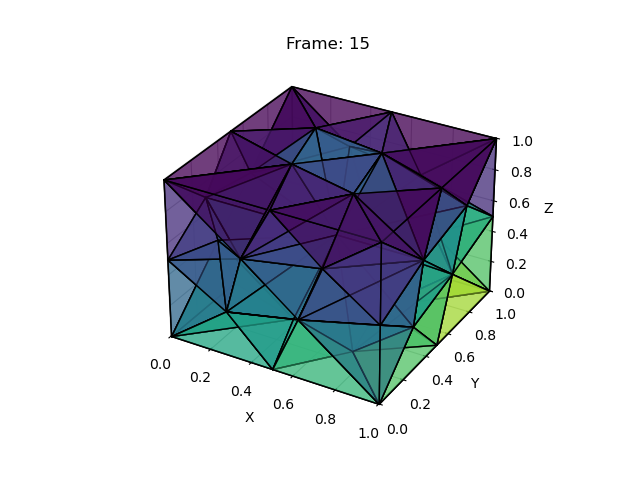

In [16]:
dir_idx = 1
print(f"Current direction: {dir_vecs[dir_idx]}")
task_graph = task_graphs[dir_idx]

# Compute the levels using the task_graph
tetrahedron_levels = compute_levels(task_graph)

# Group tetrahedrons by their levels
grouped_tetrahedrons = {}
for idx, level in tetrahedron_levels.items():
    if level not in grouped_tetrahedrons:
        grouped_tetrahedrons[level] = []
    grouped_tetrahedrons[level].append(idx)

# Create a color mapping based on tetrahedron orders
unique_orders = set(tetrahedron_levels.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_orders)))  # Use a colormap
order_color_mapping = {order: colors[i] for i, order in enumerate(sorted(unique_orders))}

# Function to plot all tetrahedrons of a specific order
def plot_tetrahedrons_by_order(ax, tetrahedron_order, nodes, tets_to_faces):
    if tetrahedron_order in grouped_tetrahedrons:
        for tetrahedron_idx in grouped_tetrahedrons[tetrahedron_order]:
            tetrahedron_faces = tets_to_faces[tetrahedron_idx]
            color = order_color_mapping[tetrahedron_order]  # Get the color for the current tetrahedron order
            
            for face in tetrahedron_faces:
                face_coords = nodes[face]
                poly3d = Poly3DCollection([face_coords], facecolors=color, edgecolors='black', alpha=0.5)
                ax.add_collection3d(poly3d)

# Function to update the plot during animation
def update(frame, ax, nodes, tets_to_faces):
    ax.clear()
    
    # Plot all tetrahedrons up to the current frame
    for order in range(frame + 1):
        plot_tetrahedrons_by_order(ax, order, nodes, tets_to_faces)
    
    # Set limits and labels for the axes
    ax.set_xlim([np.min(nodes[:, 0]), np.max(nodes[:, 0])])
    ax.set_ylim([np.min(nodes[:, 1]), np.max(nodes[:, 1])])
    ax.set_zlim([np.min(nodes[:, 2]), np.max(nodes[:, 2])])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Frame: {frame}')

# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create animation
num_frames = len(unique_orders)  # Number of unique orders
anim = FuncAnimation(fig, update, frames=num_frames, 
                     fargs=(ax, nodes, tets_to_faces), 
                     interval=1000)

# Save the animation as an MP4 file
# Set the path to the ffmpeg executable
ffmpeg_path = r';C:\Users\eappe\ffmpeg-2024-10-24-git-153a6dc8fa-full_build\bin\ffmpeg.exe'  # Use the correct path to ffmpeg.exe
os.environ['PATH'] += ffmpeg_path
writer = FFMpegWriter(fps=1)
anim_fname = f"animation-{dir_idx}.mp4"
anim.save(anim_fname, writer=writer)

# Display a message indicating that the animation has been saved
print(f"Animation saved as '{anim_fname}'.")

# Also save animation as HTML file
anim_fname_HTML = f"animation-{dir_idx}.html"
anim.save(anim_fname_HTML, writer='html', fps=15)

# Display the HTML animation
HTML(anim_fname_HTML)